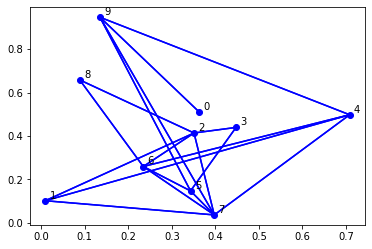

In [67]:
import numpy as np
import algos.graphdrawing as gd
      
V, adj_V = gd.gen_graph()
gd.draw(V, adj_V)

# Edge-Edge Repulsion (Lin & Yen, 2012)
Apply forces based on the angle formed by incident edges.

Angular resolution: 0.9017291761007586


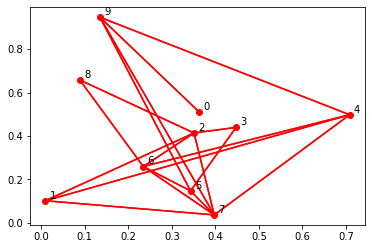

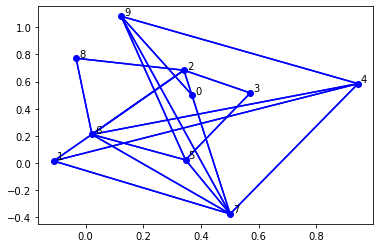

Angular resolution: 0.9676525405824926


In [79]:
import algos.lin_yen as ly
import algos.geometry as geo

gd.draw(V, adj_V, 'r')
print(f'Angular resolution: {geo.get_angular_res(V, adj_V)}')
W = ly.ee_repulsion(V, adj_V)
plt.show()

gd.draw(W, adj_V)
plt.show()

print(f'Angular resolution: {geo.get_angular_res(W, adj_V)}')

# Force-directed edge-vertex repulsion

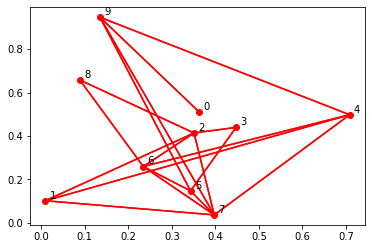

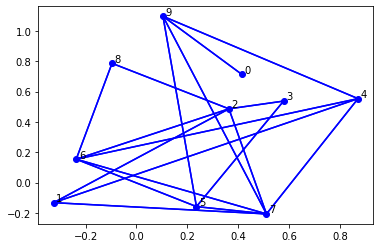

In [81]:
import numpy as np
import math

def is_left(p, q, r):
  # returns whether r is left of line pq
  s = (q[0] - p[0]) * (r[1] - p[1]) - (q[1] - p[1]) * (r[0] - [0])
  if s > 0:
    return True
  return False

def get_angle(v, w, u):
  '''
  Gets angle between vectors vu and vw.
  '''
  vu = np.subtract(u, v)
  vw = np.subtract(w, v)
  ret = np.arccos(np.dot(vu, vw) / (card(vu) * card(vw)))
  return ret
  
def ev_repulsion(V, adj_V, N=5, C1=1, C2=1, C3=1):
  W = V.copy()
  for a in range(N):
    F = np.subtract(V, W)
    F = np.multiply(C1, F)
    for i in range(len(V)):
      v = W[i]
      for j in range(len(V)):
        if i == j:
          continue
        w = W[j]
        for k in adj_V[j]:
          if i == k:
            continue
          u = W[k]
          vu = np.subtract(v, u)
          vw = np.subtract(v, w)
          vu_u = np.divide(vu, geo.card(vu))
          vw_u = np.divide(vw, geo.card(vw))
          bis = np.add(vu_u, vw_u)
          F_ang = np.divide(bis, geo.card(bis))
          uw = np.subtract(u, w)
          uw = np.divide(uw, 2)
          uwu = (w - v) + uw
          F_mag = C2 / geo.card(v - uwu)
          F[i] += (F_mag * F_ang)
    for i in range(len(V)):
      W[i] += np.multiply(C3, F[i])
  return W
      
gd.draw(V, adj_V, 'r')
plt.show()
W = ev_repulsion(V, adj_V, N=10, C1=1, C2=1, C3=0.001)
gd.draw(W, adj_V)
plt.show()

# Vertex-vertex repulsion (Birchfield & Overbye, 2018)

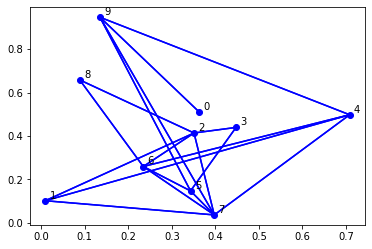

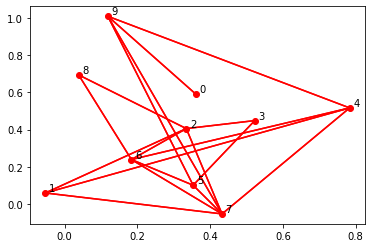

In [89]:
import algos.birchfield as bf
import algos
from importlib import reload

reload(algos.birchfield)
gd.draw(V, adj_V, 'b')
plt.show()
W = bf.force_directed(V, adj_V, N=10, C1=2, C2=0.1, C3=0.005)
gd.draw(W, adj_V, 'r')

# Frankenstein algorithm (Lin & Yen with Birchfield & Overbye)
Use the edge incident repulsion part of the algorithm from Lin & Yen and combine it with the part of the algorithm by Birchfield & Overbye where vertices are attracted to their initial positions.

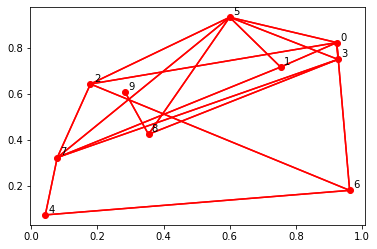

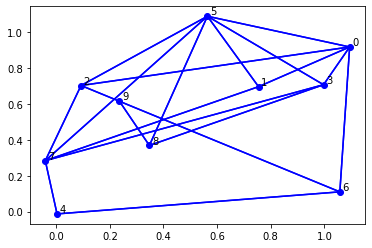

In [24]:
import algos.frankenstein as fs
import algos
from importlib import reload

reload(fs)
reload(algos)
gd.draw(V, adj_V, color='r')
W = fs.frankenstein(V, adj_V, N=5, C0=1, C6=0.005)
gd.draw(W, adj_V)

# Line intersections

[[0.28848892 0.35667277]
 [0.22131077 0.29530302]
 [0.30169844 0.36874016]
 [0.36462112 0.30300971]
 [0.40734839 0.32721718]
 [0.25325273 0.23991307]
 [0.31042026 0.27230179]
 [0.25001689 0.23807978]
 [0.32681591 0.28159087]
 [0.37335817 0.23211636]
 [0.36208727 0.32356965]
 [0.29345963 0.33755021]
 [0.30592683 0.35406904]
 [0.24894431 0.50880292]
 [0.26587704 0.49302853]
 [0.41568003 0.35052818]
 [0.3554865  0.18211343]
 [0.30460932 0.29465678]
 [0.32071516 0.30275843]] {0: [[1, 2], [5, 9]], 1: [[1, 2], [6, 8]], 2: [[1, 2], [7, 9]], 3: [[1, 4], [2, 7]], 4: [[1, 4], [3, 5]], 5: [[1, 4], [5, 6]], 6: [[1, 4], [5, 9]], 7: [[1, 4], [6, 7]], 8: [[1, 4], [7, 9]], 9: [[2, 7], [3, 5]], 10: [[2, 7], [4, 6]], 11: [[2, 6], [5, 9]], 12: [[2, 6], [7, 9]], 13: [[2, 8], [5, 9]], 14: [[2, 8], [7, 9]], 15: [[3, 5], [4, 6]], 16: [[3, 5], [7, 9]], 17: [[4, 6], [5, 9]], 18: [[4, 6], [7, 9]]}


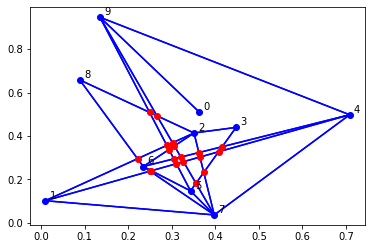

In [71]:
import matplotlib.pyplot as plt
from importlib import reload

reload(gd)
reload(geo)

E = geo.get_edges(V, adj_V)
C, adj_C = geo.get_intersects(V, E)
print(C, adj_C)
gd.draw(V, adj_V, 'b')
plt.plot(C[:,0], C[:,1], 'ro')
plt.show()

# Used later for cross resolution maximization

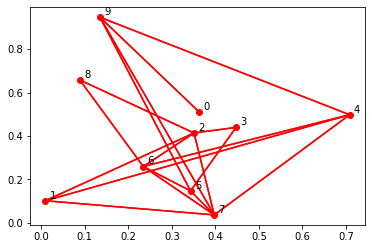

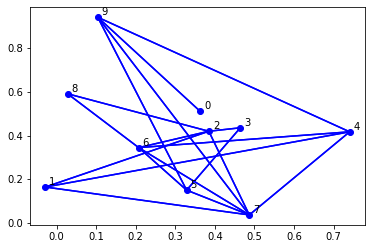

In [174]:
reload(ly)
W = ly.cross_repulsion(V, E, C, adj_C, N=10, C0=1, C1=0.005, C2=0.005)
draw(V, adj_V, 'r')
draw(W, adj_V)